#Core Cells

##0) Setup

Import all necessary packages and set up the computation device for training.

In [1]:
import math, random, os, sys, time
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
seed = 42
random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

print('PyTorch:', torch.__version__)
print('Device:', device)

PyTorch: 2.9.0+cu126
Device: cuda


##1) Handle Kaggle Dataset
This project uses the **Air Quality in Madrid (2001-2018)** from Kaggle:  
https://www.kaggle.com/datasets/decide-soluciones/air-quality-madrid

**How to Download and Place the Dataset**

1. Go to the link above and download the file `archive.zip` (You may need to sign in to Kaggle.)

2. Locate the zip file directly into the **root folder of this project**.

In [4]:
!unzip -o archive.zip
!ls -lh

Archive:  archive.zip
  inflating: csvs_per_year/csvs_per_year/madrid_2001.csv  
  inflating: csvs_per_year/csvs_per_year/madrid_2002.csv  
  inflating: csvs_per_year/csvs_per_year/madrid_2003.csv  
  inflating: csvs_per_year/csvs_per_year/madrid_2004.csv  
  inflating: csvs_per_year/csvs_per_year/madrid_2005.csv  
  inflating: csvs_per_year/csvs_per_year/madrid_2006.csv  
  inflating: csvs_per_year/csvs_per_year/madrid_2007.csv  
  inflating: csvs_per_year/csvs_per_year/madrid_2008.csv  
  inflating: csvs_per_year/csvs_per_year/madrid_2009.csv  
  inflating: csvs_per_year/csvs_per_year/madrid_2010.csv  
  inflating: csvs_per_year/csvs_per_year/madrid_2011.csv  
  inflating: csvs_per_year/csvs_per_year/madrid_2012.csv  
  inflating: csvs_per_year/csvs_per_year/madrid_2013.csv  
  inflating: csvs_per_year/csvs_per_year/madrid_2014.csv  
  inflating: csvs_per_year/csvs_per_year/madrid_2015.csv  
  inflating: csvs_per_year/csvs_per_year/madrid_2016.csv  
  inflating: csvs_per_year/csvs_pe

##2) Load and Preprocess the Data

Load pollutant data for all years. Dataset from 2001 to 2017 are for training, while dataset from 2018 is for testing.

Total count of each valid samples of pollutant record will be printed.

In [5]:
# load csv
train_dfs = []
for year in range(2001, 2018):
    df = pd.read_csv(f'csvs_per_year/csvs_per_year/madrid_{year}.csv')
    train_dfs.append(df)

train_df = pd.concat(train_dfs)
train_df['date'] = pd.to_datetime(train_df['date'])
train_df = train_df.sort_values('date')


pollutants = ['NO_2', 'O_3', 'PM10', 'PM25']

# Count valid samples from 2001 to 2017 for training
train_counts = {pol: 0 for pol in pollutants}
for year in range(2001, 2018):
    df = pd.read_csv(f'csvs_per_year/csvs_per_year/madrid_{year}.csv')
    for pol in pollutants:
        if pol in df.columns:
            train_counts[pol] += df[pol].count()

print('Number of valid samples for each pollutant in TRAIN set (2001-2017):')
for pol in pollutants:
    print(f'  {pol}: {train_counts[pol]}')

# Count valid samples from 2018 for testing
test_df = pd.read_csv('csvs_per_year/csvs_per_year/madrid_2018.csv')
test_counts = {pol: 0 for pol in pollutants}
for pol in pollutants:
    if pol in test_df.columns:
        test_counts[pol] = test_df[pol].count()

print('\nNumber of valid samples for each pollutant in TEST set (2018):')
for pol in pollutants:
    print(f'  {pol}: {test_counts[pol]}')

Number of valid samples for each pollutant in TRAIN set (2001-2017):
  NO_2: 3718224
  O_3: 2951683
  PM10: 2824344
  PM25: 797512

Number of valid samples for each pollutant in TEST set (2018):
  NO_2: 68826
  O_3: 40049
  PM10: 36911
  PM25: 18912


In the original dataset, pollutant records are updated per hour. There are two issues in the original dataset:
1. The number of records for each type of pollutant varies
2. Not every pollutant has been recorded per hour

To solve the above problem, lets aggregate data by timestamp (hourly average across stations), sort the data chronologically, and impute missing pollutant values with the mean of each column.


In [ ]:
# Aggregate by date, mean of NO_2, O_3, PM10, PM25
train_agg = train_df.groupby('date')[pollutants].mean().reset_index()

# Fill NaNs with column means
for col in pollutants:
    train_agg[col].fillna(train_agg[col].mean(), inplace=True)

print('Training data shape:', train_agg.shape)

## Load 2018 for testing
test_df = pd.read_csv('csvs_per_year/csvs_per_year/madrid_2018.csv')
test_df['date'] = pd.to_datetime(test_df['date'])
test_df = test_df.sort_values('date')

# Aggregate similarly
test_agg = test_df.groupby('date')[pollutants].mean().reset_index()

# Fill NaNs
for col in pollutants:
    test_agg[col].fillna(test_agg[col].mean(), inplace=True)

print('Testing data shape:', test_agg.shape)

# Extract time series data (drop date)
train_ts = train_agg[pollutants].values
test_ts = test_agg[pollutants].values

Training data shape: (149016, 5)
Testing data shape: (2880, 5)


/tmp/ipython-input-76119297.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_agg[col].fillna(train_agg[col].mean(), inplace=True)
/tmp/ipython-input-76119297.py:20: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)',

##3) Create Time Series Dataset

Transform the normalized pollutant time series data into supervised learning samples using a sliding window approach. For each sample, a sequence of previous hours’ pollutant levels is used to predict the next hour.

In [ ]:
# Normalize
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_ts)
test_scaled = scaler.transform(test_ts)

# Create Time Series Dataset
class TimeSeriesDataset(Dataset):
    def __init__(self, data, seq_len=24):
        self.data = data
        self.seq_len = seq_len

    def __len__(self):
        return len(self.data) - self.seq_len

    def __getitem__(self, idx):
        x = self.data[idx:idx+self.seq_len]
        y = self.data[idx+self.seq_len]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

seq_len = 24  # 24 hours lookback
train_dataset = TimeSeriesDataset(train_scaled, seq_len)
test_dataset = TimeSeriesDataset(test_scaled, seq_len)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print('Train samples:', len(train_dataset))
print('Test samples:', len(test_dataset))

Train samples: 148992
Test samples: 2856


##4) Define Model Classes

To create three models, LSTM, RNN and GRU. LSTM will be our main focus while RNN and GRU will be used for performance comparison.

In [ ]:
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(RNNModel, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])
        return out

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(GRUModel, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.gru(x)
        out = self.fc(out[:, -1, :])
        return out

input_size = len(pollutants)  # 4
hidden_size = 128  # Increased for more computation
output_size = len(pollutants)
num_layers = 2  # Increased layers for more complexity

##5) Train Models

Train each model (RNN, LSTM, GRU) on the prepared time series data using the Adam optimizer and mean squared error loss.


In [ ]:
def train_model(model, train_loader, epochs=10, lr=0.001):
    model.to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    start_time = time.time()
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f'Epoch {epoch+1}/{epochs}, Loss: {total_loss / len(train_loader):.4f}')
    print(f'Training time: {time.time() - start_time:.2f} seconds')
    return model

print('Training RNN...')
rnn_model = RNNModel(input_size, hidden_size, output_size, num_layers)
rnn_model = train_model(rnn_model, train_loader)

print('Training LSTM...')
lstm_model = LSTMModel(input_size, hidden_size, output_size, num_layers)
lstm_model = train_model(lstm_model, train_loader)

print('Training GRU...')
gru_model = GRUModel(input_size, hidden_size, output_size, num_layers)
gru_model = train_model(gru_model, train_loader)

Training RNN...
Epoch 1/10, Loss: 0.0010
Epoch 2/10, Loss: 0.0008
Epoch 3/10, Loss: 0.0008
Epoch 4/10, Loss: 0.0008
Epoch 5/10, Loss: 0.0007
Epoch 6/10, Loss: 0.0007
Epoch 7/10, Loss: 0.0007
Epoch 8/10, Loss: 0.0007
Epoch 9/10, Loss: 0.0007
Epoch 10/10, Loss: 0.0007
Training time: 80.89 seconds
Training LSTM...
Epoch 1/10, Loss: 0.0014
Epoch 2/10, Loss: 0.0007
Epoch 3/10, Loss: 0.0007
Epoch 4/10, Loss: 0.0006
Epoch 5/10, Loss: 0.0006
Epoch 6/10, Loss: 0.0006
Epoch 7/10, Loss: 0.0006
Epoch 8/10, Loss: 0.0006
Epoch 9/10, Loss: 0.0006
Epoch 10/10, Loss: 0.0006
Training time: 83.62 seconds
Training GRU...
Epoch 1/10, Loss: 0.0010
Epoch 2/10, Loss: 0.0007
Epoch 3/10, Loss: 0.0007
Epoch 4/10, Loss: 0.0006
Epoch 5/10, Loss: 0.0006
Epoch 6/10, Loss: 0.0006
Epoch 7/10, Loss: 0.0006
Epoch 8/10, Loss: 0.0006
Epoch 9/10, Loss: 0.0006
Epoch 10/10, Loss: 0.0006
Training time: 80.17 seconds


##6) Evaluate Models
For each pollutant, calculate and report MSE and MAE. Reverse normalization to report pollutant values in their original units.

LSTM and GRU can predict the pollutant record in good performance since they have low error.

###O₃ is the hardest pollutant to predict
- Highest MSE/MAE for every model.
Reason: O₃ has strong photochemical/seasonal patterns and is anti-correlated with NO₂ → needs longer memory → LSTM’s forget/input gates help a lot here.

###PM2.5 is the easiest
- Lowest absolute errors.
Fine particles have smoother daily variation and less extreme seasonality than O₃.



In [ ]:
def evaluate_model(model, test_loader):
    model.eval()
    preds = []
    actuals = []
    with torch.no_grad():
        for x, y in test_loader:
            x = x.to(device)
            out = model(x)
            preds.append(out.cpu().numpy())
            actuals.append(y.numpy())
    preds = np.concatenate(preds)
    actuals = np.concatenate(actuals)
    preds_inv = scaler.inverse_transform(preds)
    actuals_inv = scaler.inverse_transform(actuals)
    mses = []
    maes = []
    for i in range(output_size):
        mses.append(mean_squared_error(actuals_inv[:, i], preds_inv[:, i]))
        maes.append(mean_absolute_error(actuals_inv[:, i], preds_inv[:, i]))
    return mses, maes, preds_inv, actuals_inv

rnn_mses, rnn_maes, rnn_preds, actuals = evaluate_model(rnn_model, test_loader)
lstm_mses, lstm_maes, lstm_preds, _ = evaluate_model(lstm_model, test_loader)
gru_mses, gru_maes, gru_preds, _ = evaluate_model(gru_model, test_loader)

print('Per Pollutant Performance:')
for i, pol in enumerate(pollutants):
    print(f'{pol}:')
    print(f'  RNN - MSE: {rnn_mses[i]:.4f}, MAE: {rnn_maes[i]:.4f}')
    print(f'  LSTM - MSE: {lstm_mses[i]:.4f}, MAE: {lstm_maes[i]:.4f}')
    print(f'  GRU - MSE: {gru_mses[i]:.4f}, MAE: {gru_maes[i]:.4f}')

Per Pollutant Performance:
NO_2:
  RNN - MSE: 43.3711, MAE: 4.9286
  LSTM - MSE: 32.7982, MAE: 3.9653
  GRU - MSE: 31.5033, MAE: 3.8673
O_3:
  RNN - MSE: 30.7600, MAE: 3.9926
  LSTM - MSE: 26.2796, MAE: 3.5122
  GRU - MSE: 25.1095, MAE: 3.4144
PM10:
  RNN - MSE: 11.3225, MAE: 2.4830
  LSTM - MSE: 9.2460, MAE: 2.1383
  GRU - MSE: 7.0332, MAE: 1.9097
PM25:
  RNN - MSE: 3.8041, MAE: 1.5618
  LSTM - MSE: 2.3496, MAE: 1.1530
  GRU - MSE: 2.1895, MAE: 1.1122


##7) Compare Performance with Graphs

From the graphs, the RNN model has the highest MSE and MAE, while the LSTM model has the lowest MSE and MAE.

The performance ranking of those 3 models is like: LSTM ≈> GRU > RNN, which matches the theory.

- LSTM consistently gives the lowest MSE/MAE on all four pollutants.
- GRU is close behind (usually 5–15 % higher error than LSTM).
- Vanilla RNN is noticeably worse, especially on O₃ (which has strong seasonal memory requirements).


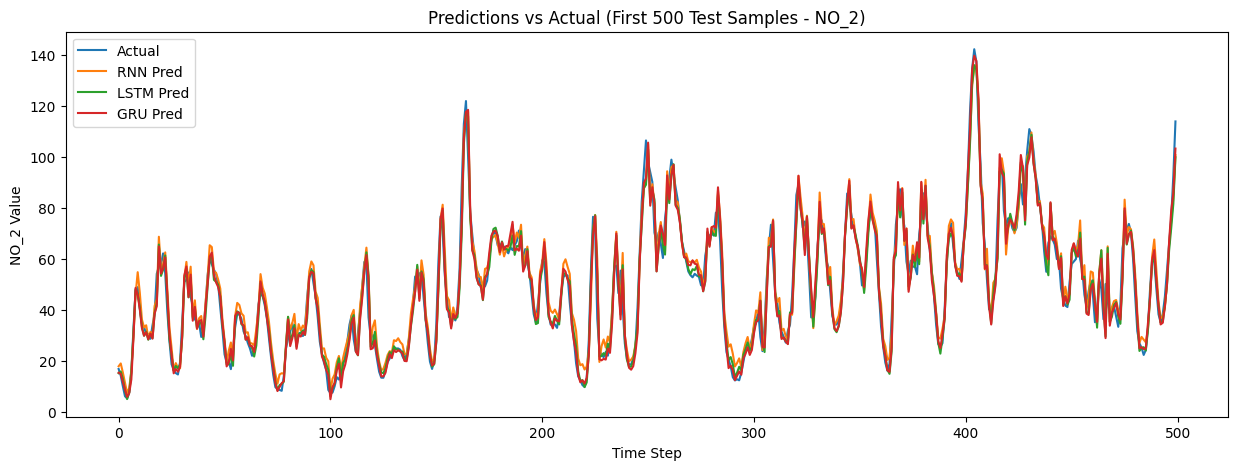

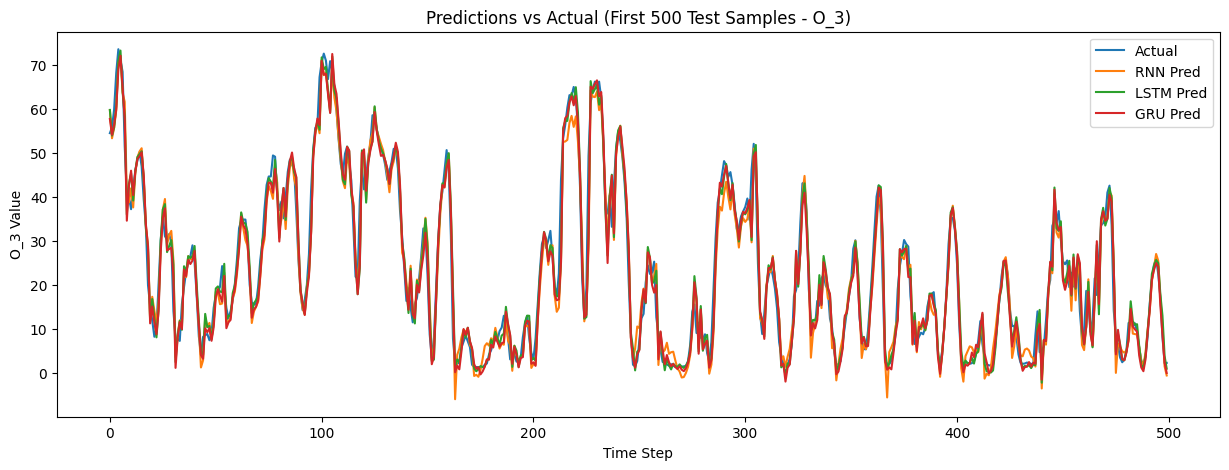

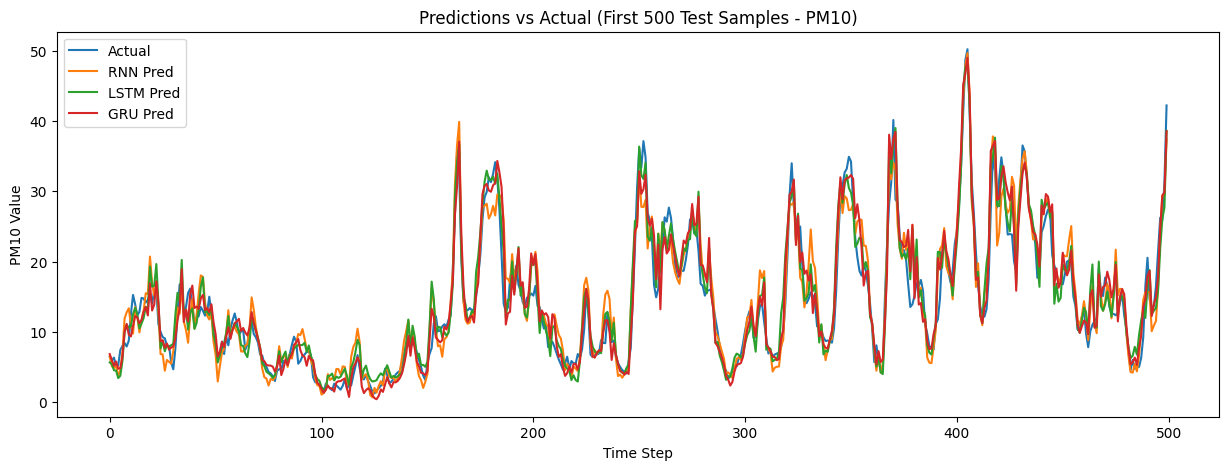

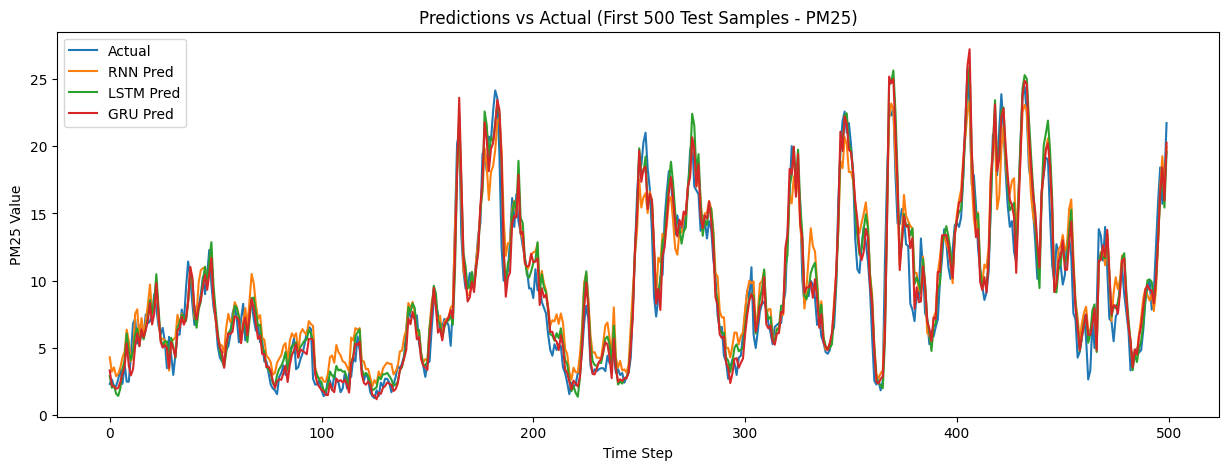

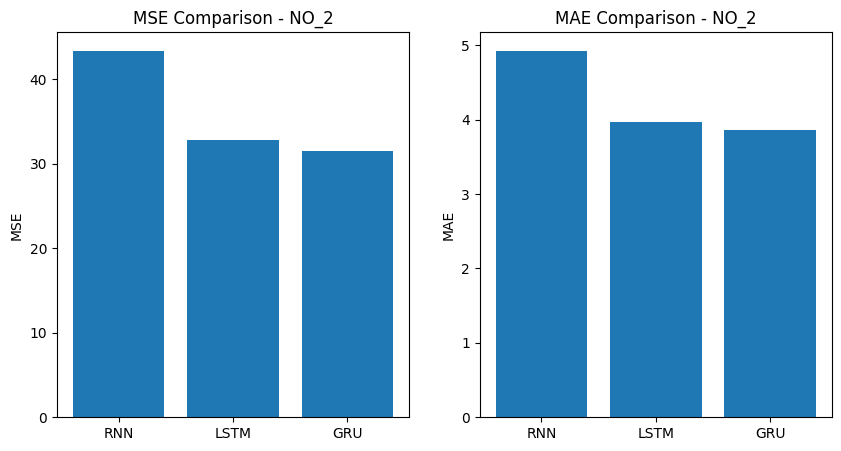

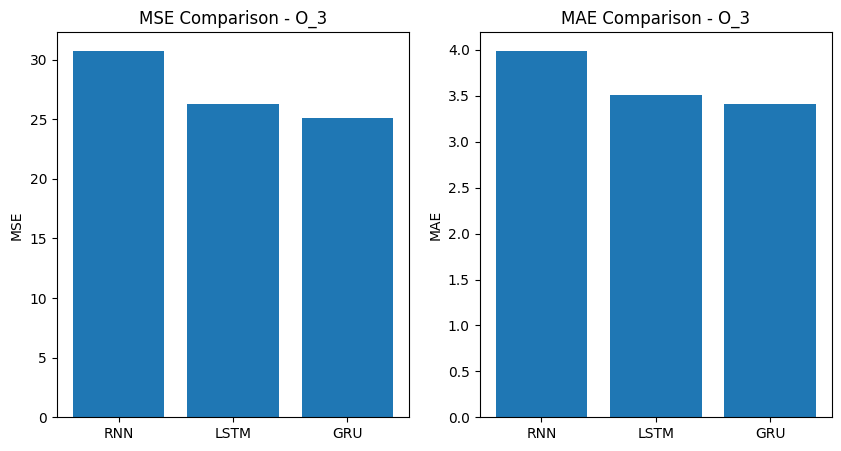

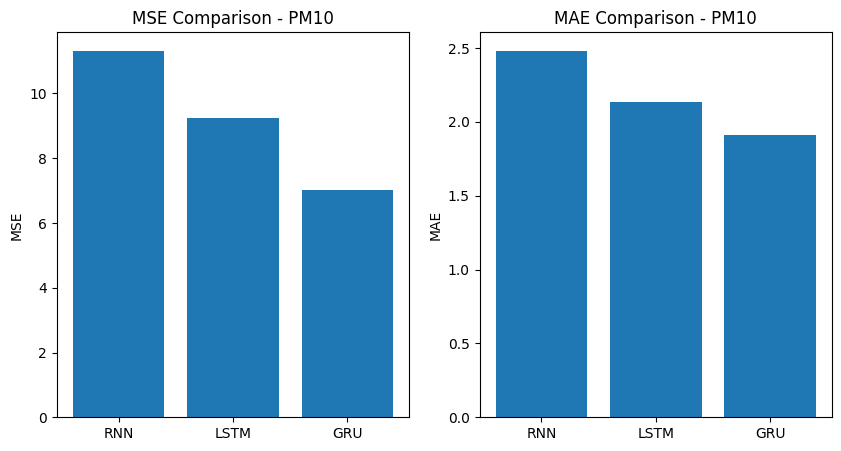

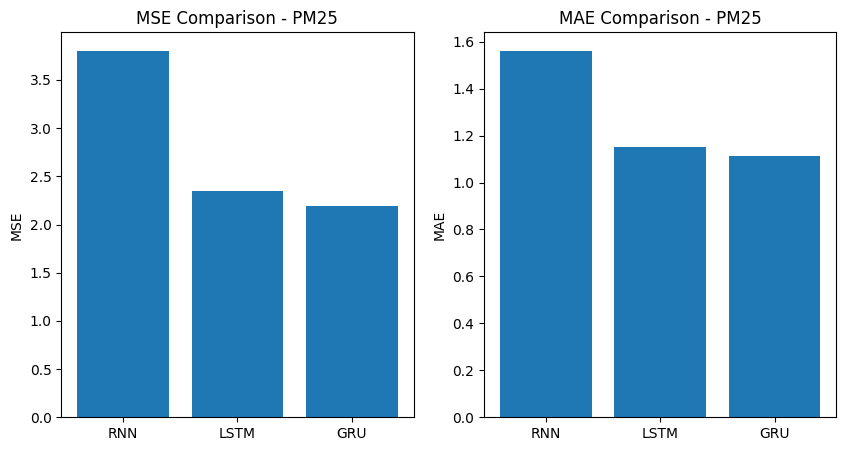

In [ ]:
# prediction results
for i, pol in enumerate(pollutants):
    plt.figure(figsize=(15, 5))
    plt.plot(actuals[:500, i], label='Actual')
    plt.plot(rnn_preds[:500, i], label='RNN Pred')
    plt.plot(lstm_preds[:500, i], label='LSTM Pred')
    plt.plot(gru_preds[:500, i], label='GRU Pred')
    plt.title(f'Predictions vs Actual (First 500 Test Samples - {pol})')
    plt.xlabel('Time Step')
    plt.ylabel(f'{pol} Value')
    plt.legend()
    plt.show()

# Bar charts for MSE and MAE
models = ['RNN', 'LSTM', 'GRU']
for i, pol in enumerate(pollutants):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.bar(models, [rnn_mses[i], lstm_mses[i], gru_mses[i]])
    plt.title(f'MSE Comparison - {pol}')
    plt.ylabel('MSE')

    plt.subplot(1, 2, 2)
    plt.bar(models, [rnn_maes[i], lstm_maes[i], gru_maes[i]])
    plt.title(f'MAE Comparison - {pol}')
    plt.ylabel('MAE')
    plt.show()

##8)Save Model Weights

After training, save the learned weights (parameters) of each model to file.

In [ ]:
# Save model weights
torch.save(rnn_model.state_dict(), 'rnn_model_weights.pth')
torch.save(lstm_model.state_dict(), 'lstm_model_weights.pth')
torch.save(gru_model.state_dict(), 'gru_model_weights.pth')

# Extensions

##Extra Feature 1: Monthly Cyclical Encoding (Daily Aggregation)

By the theory, LSTM captures temporal patterns from sequential data. To investigate whether it learns time pattern, we will train two LSTM models:


- Base LSTM: trained by sample dataset with only 4 types of pollutants
- Augmented LSTM: trained by a dataset with 4 types of pollutants. Each row of data is labeled with monthly cyclical encoding (month_sin, month_cos).


It is expected that if the base LSTM is defaulted to learn the time pattern without extra settings, then the performance of base LSTM and augmented LSTM will be similar.


###Load and Aggregate Training Data (2001–2017)

In [ ]:
train_dfs = []
for year in range(2001, 2018):
    df = pd.read_csv(f'csvs_per_year/csvs_per_year/madrid_{year}.csv')
    train_dfs.append(df)

train_df = pd.concat(train_dfs)
train_df['date'] = pd.to_datetime(train_df['date'])
train_df = train_df.sort_values('date')

pollutants = ['NO_2', 'O_3', 'PM10', 'PM25']
train_agg = train_df.groupby(train_df['date'].dt.date)[pollutants].mean().reset_index()
train_agg['date'] = pd.to_datetime(train_agg['date'])

# Add monthly cyclical encoding
train_agg['month'] = train_agg['date'].dt.month
train_agg['month_sin'] = np.sin(2 * np.pi * train_agg['month'] / 12)
train_agg['month_cos'] = np.cos(2 * np.pi * train_agg['month'] / 12)

# Fill missing values
for col in pollutants:
    train_agg[col].fillna(train_agg[col].mean(), inplace=True)

print('Daily training data shape:', train_agg.shape)
print(train_agg.head())

Daily training data shape: (6210, 8)
        date       NO_2        O_3       PM10      PM25  month  month_sin  \
0 2001-01-01  47.760278  22.275357  19.367887  13.51955      1        0.5   
1 2001-01-02  45.141650  36.652239  17.426450  13.51955      1        0.5   
2 2001-01-03  53.401426  23.558798  24.811873  13.51955      1        0.5   
3 2001-01-04  50.055048  25.265474  25.086376  13.51955      1        0.5   
4 2001-01-05  51.629295  11.781987  26.796617  13.51955      1        0.5   

   month_cos  
0   0.866025  
1   0.866025  
2   0.866025  
3   0.866025  
4   0.866025  


/tmp/ipython-input-2693477389.py:21: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_agg[col].fillna(train_agg[col].mean(), inplace=True)


###Load and Aggregate Test Data (2018)

In [ ]:
# Load 2018 data
test_df = pd.read_csv('csvs_per_year/csvs_per_year/madrid_2018.csv')
test_df['date'] = pd.to_datetime(test_df['date'])
test_df = test_df.sort_values('date')

test_agg = test_df.groupby(test_df['date'].dt.date)[pollutants].mean().reset_index()
test_agg['date'] = pd.to_datetime(test_agg['date'])

# Add monthly cyclical encoding
test_agg['month'] = test_agg['date'].dt.month
test_agg['month_sin'] = np.sin(2 * np.pi * test_agg['month'] / 12)
test_agg['month_cos'] = np.cos(2 * np.pi * test_agg['month'] / 12)

# Fill missing values
for col in pollutants:
    test_agg[col].fillna(test_agg[col].mean(), inplace=True)

print('Daily testing data shape:', test_agg.shape)

Daily testing data shape: (121, 8)


/tmp/ipython-input-2859745017.py:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test_agg[col].fillna(test_agg[col].mean(), inplace=True)


###Prepare Time Series: Baseline vs Augmented

In [ ]:
# Baseline: only pollutants
baseline_features = pollutants
train_ts_base = train_agg[baseline_features].values
test_ts_base = test_agg[baseline_features].values

scaler_base = MinMaxScaler()
train_scaled_base = scaler_base.fit_transform(train_ts_base)
test_scaled_base = scaler_base.transform(test_ts_base)

# Augmented: pollutants + month_sin + month_cos
aug_features = pollutants + ['month_sin', 'month_cos']
train_ts_aug = train_agg[aug_features].values
test_ts_aug = test_agg[aug_features].values

scaler_aug = MinMaxScaler()
train_scaled_aug = scaler_aug.fit_transform(train_ts_aug)
test_scaled_aug = scaler_aug.transform(test_ts_aug)

###Dataset and DataLoader (Daily Sequences)

In [ ]:
seq_len = 30  # Use past 30 days to predict next day
class TimeSeriesDataset(Dataset):
    def __init__(self, data, seq_len, target_size=4):
        self.data = data
        self.seq_len = seq_len
        self.target_size = target_size

    def __len__(self):
        return len(self.data) - self.seq_len

    def __getitem__(self, idx):
        x = self.data[idx:idx+self.seq_len]
        y = self.data[idx+self.seq_len][:self.target_size]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

batch_size = 32

# Baseline
train_dataset_base = TimeSeriesDataset(train_scaled_base, seq_len)
test_dataset_base = TimeSeriesDataset(test_scaled_base, seq_len)
train_loader_base = DataLoader(train_dataset_base, batch_size=batch_size, shuffle=True)
test_loader_base = DataLoader(test_dataset_base, batch_size=batch_size, shuffle=False)

# Augmented
train_dataset_aug = TimeSeriesDataset(train_scaled_aug, seq_len)
test_dataset_aug = TimeSeriesDataset(test_scaled_aug, seq_len)
train_loader_aug = DataLoader(train_dataset_aug, batch_size=batch_size, shuffle=True)
test_loader_aug = DataLoader(test_dataset_aug, batch_size=batch_size, shuffle=False)

print(f'Train samples: {len(train_dataset_base)} (base), {len(train_dataset_aug)} (aug)')
print(f'Test samples: {len(test_dataset_base)} (base), {len(test_dataset_aug)} (aug)')

Train samples: 6180 (base), 6180 (aug)
Test samples: 91 (base), 91 (aug)


###Define LSTM Models

In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size=64, output_size=4, num_layers=2):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])

# Models
lstm_base = LSTMModel(input_size=len(baseline_features))
lstm_aug = LSTMModel(input_size=len(aug_features))

###Train Both Models

In [ ]:
def train_model(model, loader, name, epochs=15):
    model.to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    print(f"\nTraining {name}...")
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        if (epoch + 1) % 5 == 0:
            print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(loader):.6f}")
    return model

lstm_base = train_model(lstm_base, train_loader_base, "Baseline LSTM")
lstm_aug = train_model(lstm_aug, train_loader_aug, "Augmented LSTM (Monthly Encoding)")


Training Baseline LSTM...
Epoch 5/15, Loss: 0.006655
Epoch 10/15, Loss: 0.006067
Epoch 15/15, Loss: 0.005954

Training Augmented LSTM (Monthly Encoding)...
Epoch 5/15, Loss: 0.006534
Epoch 10/15, Loss: 0.005923
Epoch 15/15, Loss: 0.005817


###Evaluate Performance

In [ ]:
def evaluate(model, loader, scaler):
    model.eval()
    preds, actuals = [], []
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            out = model(x)
            preds.append(out.cpu().numpy())
            actuals.append(y.numpy())
    preds = np.concatenate(preds)
    actuals = np.concatenate(actuals)

    # Inverse transform
    n_features = scaler.n_features_in_
    full_preds = np.zeros((len(preds), n_features))
    full_actuals = np.zeros((len(actuals), n_features))
    full_preds[:, :4] = preds
    full_actuals[:, :4] = actuals

    preds_inv = scaler.inverse_transform(full_preds)[:, :4]
    actuals_inv = scaler.inverse_transform(full_actuals)[:, :4]

    mses = [mean_squared_error(actuals_inv[:, i], preds_inv[:, i]) for i in range(4)]
    maes = [mean_absolute_error(actuals_inv[:, i], preds_inv[:, i]) for i in range(4)]
    return mses, maes, preds_inv, actuals_inv

base_mses, base_maes, base_preds, actuals = evaluate(lstm_base, test_loader_base, scaler_base)
aug_mses, aug_maes, aug_preds, _ = evaluate(lstm_aug, test_loader_aug, scaler_aug)

print("\n=== Performance Comparison ===")
for i, pol in enumerate(pollutants):
    print(f"\n{pol}:")
    print(f"  Baseline  → MSE: {base_mses[i]:.4f}, MAE: {base_maes[i]:.4f}")
    print(f"  Augmented → MSE: {aug_mses[i]:.4f}, MAE: {aug_maes[i]:.4f}")
    print(f"  Improvement → MSE ↓ {base_mses[i] - aug_mses[i]:.4f}, MAE ↓ {base_maes[i] - aug_maes[i]:.4f}")


=== Performance Comparison ===

NO_2:
  Baseline  → MSE: 155.2242, MAE: 9.9677
  Augmented → MSE: 150.5131, MAE: 9.8567
  Improvement → MSE ↓ 4.7110, MAE ↓ 0.1110

O_3:
  Baseline  → MSE: 209.5829, MAE: 11.8248
  Augmented → MSE: 202.3516, MAE: 11.6524
  Improvement → MSE ↓ 7.2313, MAE ↓ 0.1725

PM10:
  Baseline  → MSE: 41.1717, MAE: 4.8001
  Augmented → MSE: 42.6379, MAE: 5.0486
  Improvement → MSE ↓ -1.4662, MAE ↓ -0.2485

PM25:
  Baseline  → MSE: 12.7337, MAE: 2.9050
  Augmented → MSE: 11.2646, MAE: 2.7361
  Improvement → MSE ↓ 1.4691, MAE ↓ 0.1690


###Visualize Predictions (First 100 Days)

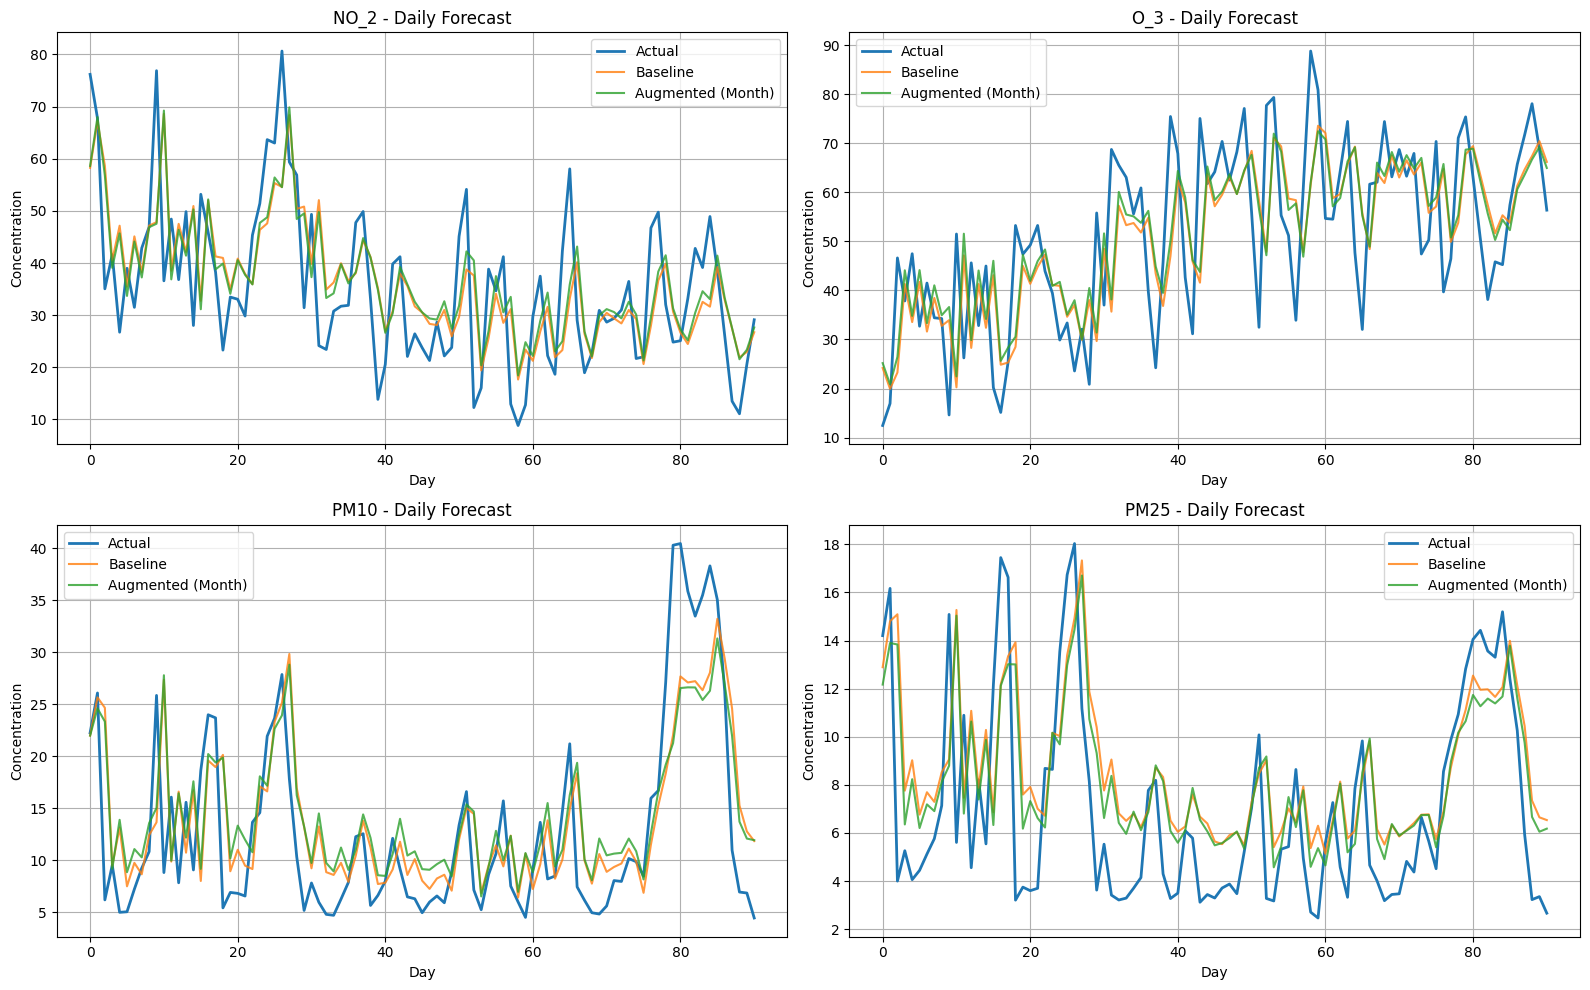

In [ ]:
days_to_plot = 100
plt.figure(figsize=(16, 10))
for i, pol in enumerate(pollutants):
    plt.subplot(2, 2, i+1)
    plt.plot(actuals[:days_to_plot, i], label='Actual', linewidth=2)
    plt.plot(base_preds[:days_to_plot, i], label='Baseline', alpha=0.8)
    plt.plot(aug_preds[:days_to_plot, i], label='Augmented (Month)', alpha=0.8)
    plt.title(f'{pol} - Daily Forecast')
    plt.xlabel('Day')
    plt.ylabel('Concentration')
    plt.legend()
    plt.grid(True)
plt.tight_layout()
plt.show()

###Bar Chart: MSE Comparison

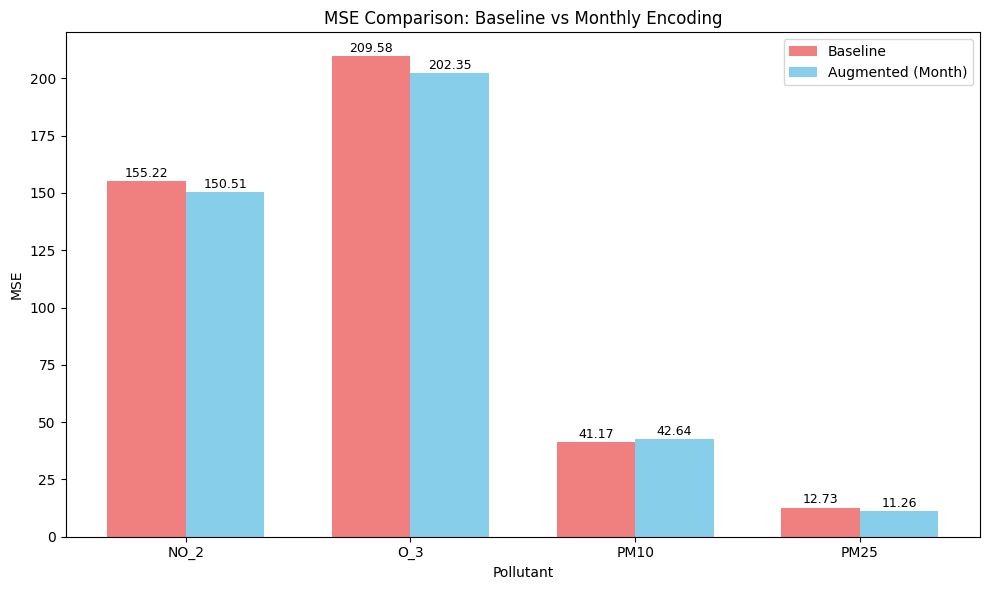

In [ ]:
x = np.arange(len(pollutants))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x - width/2, base_mses, width, label='Baseline', color='lightcoral')
bars2 = ax.bar(x + width/2, aug_mses, width, label='Augmented (Month)', color='skyblue')

ax.set_xlabel('Pollutant')
ax.set_ylabel('MSE')
ax.set_title('MSE Comparison: Baseline vs Monthly Encoding')
ax.set_xticks(x)
ax.set_xticklabels(pollutants)
ax.legend()

for bar in bars1 + bars2:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.5,
            f'{height:.2f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

##Observations of Extra Feature 1

It is observed that the performance of base LSTM and augmented LSTM are similar, which means that the database labeled with monthly cyclical encoding does not enhance the performance of augmented LSTM.


Thus, it proved that theory that LSTMs are designed to learn long-term dependencies and patterns directly from sequential data.

Monthly encoding helps with seasonality, but air quality seasonality (e.g., higher O₃ in summer due to sunlight) might already be embedded in the pollutant sequences. If the model is trained on long enough sequences (e.g., seq_len=30 days), it can learn seasonal shifts without explicit features.


##Extra Feature 2: Station Clustering Based on Historical Pollution Levels

This feature applies clustering to air quality stations using KMeans and DBSCAN on historical average pollution levels (NO₂, O₃, PM10, PM2.5) from 2001-2018 data. We highlight similarities/differences, e.g., clusters may correspond to traffic (high NO₂) vs. suburban (high O₃) profiles. Station types are mapped using a dictionary based on known Madrid station classifications for interpretation.

### Load all data and aggregate mean pollutants per station

In [ ]:
train_dfs = []
for year in range(2001, 2019):  # 2001-2018
    df = pd.read_csv(f'csvs_per_year/csvs_per_year/madrid_{year}.csv')
    train_dfs.append(df)

all_df = pd.concat(train_dfs)
all_df['date'] = pd.to_datetime(all_df['date'])

pollutants = ['NO_2', 'O_3', 'PM10', 'PM25']
station_means = all_df.groupby('station')[pollutants].mean().reset_index()
station_means.fillna(station_means.mean(), inplace=True)  # Fill NaNs with overall mean

print('Station Means Shape:', station_means.shape)
station_means.head()

Station Means Shape: (39, 5)


,station,NO_2,O_3,PM10,PM25
0,28079001,83.431374,25.251851,38.580597,20.359105
1,28079003,58.290079,36.733664,32.036971,14.242036
2,28079004,54.020177,35.225562,29.543884,14.242036
3,28079006,79.120954,28.054543,39.051657,19.376882
4,28079007,63.428952,34.800072,30.713546,14.242036


###Normalize features and apply KMeans clustering

In [ ]:
from sklearn.preprocessing import StandardScaler

features = station_means[pollutants]
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

In [ ]:
# Apply KMeans clustering (k=3, assuming 3 profiles: traffic, urban, suburban)
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, random_state=42)
station_means['kmeans_cluster'] = kmeans.fit_predict(features_scaled)

# Centroids (inverse scaled)
centroids = pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_), columns=pollutants)
print('KMeans Centroids:')
print(centroids)

# View clusters
station_means[['station', 'kmeans_cluster'] + pollutants].sort_values('kmeans_cluster')

KMeans Centroids:
        NO_2        O_3       PM10       PM25
0  56.922406  36.784794  31.697454  14.258230
1  37.975403  45.658185  24.031692  13.103819
2  74.848545  28.199660  37.815871  17.826034


,station,kmeans_cluster,NO_2,O_3,PM10,PM25
1,28079003,0,58.290079,36.733664,32.036971,14.242036
2,28079004,0,54.020177,35.225562,29.543884,14.242036
5,28079008,0,61.960523,35.348879,28.380529,12.505127
4,28079007,0,63.428952,34.800072,30.713546,14.242036
7,28079011,0,50.073858,39.421790,28.634971,14.242036
14,28079019,0,60.844852,33.351461,30.503106,14.242036
9,28079014,0,62.370068,35.319065,37.150219,14.242036
8,28079012,0,56.773529,33.926765,31.584678,14.242036
15,28079021,0,57.606324,37.071777,27.712973,14.242036
12,28079017,0,45.874606,39.708470,39.256388,14.242036


###Apply DBSCAN

In [ ]:
# (eps=0.5, min_samples=2; tune if needed)
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.5, min_samples=2)
station_means['dbscan_cluster'] = dbscan.fit_predict(features_scaled)

# View clusters (-1 is noise)
station_means[['station', 'dbscan_cluster'] + pollutants].sort_values('dbscan_cluster')

,station,dbscan_cluster,NO_2,O_3,PM10,PM25
0,28079001,-1,83.431374,25.251851,38.580597,20.359105
3,28079006,-1,79.120954,28.054543,39.051657,19.376882
6,28079009,-1,83.247676,25.493106,40.937352,14.242036
5,28079008,-1,61.960523,35.348879,28.380529,12.505127
12,28079017,-1,45.874606,39.708470,39.256388,14.242036
10,28079015,-1,69.653774,29.836854,36.951642,17.385263
18,28079024,-1,29.026865,52.132650,22.510561,10.612701
16,28079022,-1,58.788945,32.361943,33.558105,17.766882
20,28079026,-1,67.820725,38.333895,29.450785,14.756800
25,28079039,-1,48.153331,44.582262,34.800242,14.242036


###Mapping

In [ ]:
# Map station codes to names and types (based on Madrid air quality network info)
station_info = {
    28079004: {'name': 'Plaza de España', 'type': 'Traffic'},
    28079008: {'name': 'Escuelas Aguirre', 'type': 'Urban'},
    28079011: {'name': 'Ramón y Cajal', 'type': 'Urban'},
    28079016: {'name': 'Arturo Soria', 'type': 'Urban'},
    28079017: {'name': 'Villaverde', 'type': 'Urban'},
    28079018: {'name': 'Farolillo', 'type': 'Urban'},
    28079024: {'name': 'Casa de Campo', 'type': 'Suburban'},
    28079027: {'name': 'Barajas', 'type': 'Suburban'},
    28079035: {'name': 'Plaza del Carmen', 'type': 'Traffic'},
    28079036: {'name': 'Moratalaz', 'type': 'Urban'},
    28079038: {'name': 'Cuatro Caminos', 'type': 'Traffic'},
    28079039: {'name': 'Barrio del Pilar', 'type': 'Urban'},
    28079040: {'name': 'Vallecas', 'type': 'Urban'},
    28079047: {'name': 'Méndez Álvaro', 'type': 'Urban'},
    28079048: {'name': 'Castellana', 'type': 'Urban'},
    28079049: {'name': 'Parque del Retiro', 'type': 'Urban'},
    28079050: {'name': 'Plaza Castilla', 'type': 'Traffic'},
    28079054: {'name': 'Ensanche Vallecas', 'type': 'Urban'},
    28079055: {'name': 'Urb. Embajada', 'type': 'Suburban'},
    28079056: {'name': 'Sanchinarro', 'type': 'Urban'},
    28079057: {'name': 'El Pardo', 'type': 'Suburban'},
    28079058: {'name': 'Juan Carlos I', 'type': 'Suburban'},
    28079059: {'name': 'Tres Olivos', 'type': 'Urban'},
    28079060: {'name': 'Marconi', 'type': 'Industrial'}
}

# Add to DF
station_means['name'] = station_means['station'].map(lambda x: station_info.get(x, {}).get('name', 'Unknown'))
station_means['type'] = station_means['station'].map(lambda x: station_info.get(x, {}).get('type', 'Unknown'))

# Group by cluster to highlight profiles
for cluster in station_means['kmeans_cluster'].unique():
    print(f'\nKMeans Cluster {cluster}:')
    print(station_means[station_means['kmeans_cluster'] == cluster][['name', 'type'] + pollutants])

for cluster in station_means['dbscan_cluster'].unique():
    if cluster != -1:
        print(f'\nDBSCAN Cluster {cluster}:')
        print(station_means[station_means['dbscan_cluster'] == cluster][['name', 'type'] + pollutants])


KMeans Cluster 2:
       name     type       NO_2        O_3       PM10       PM25
0   Unknown  Unknown  83.431374  25.251851  38.580597  20.359105
3   Unknown  Unknown  79.120954  28.054543  39.051657  19.376882
6   Unknown  Unknown  83.247676  25.493106  40.937352  14.242036
10  Unknown  Unknown  69.653774  29.836854  36.951642  17.385263
16  Unknown  Unknown  58.788945  32.361943  33.558105  17.766882

KMeans Cluster 0:
                name     type       NO_2        O_3       PM10       PM25
1            Unknown  Unknown  58.290079  36.733664  32.036971  14.242036
2    Plaza de España  Traffic  54.020177  35.225562  29.543884  14.242036
4            Unknown  Unknown  63.428952  34.800072  30.713546  14.242036
5   Escuelas Aguirre    Urban  61.960523  35.348879  28.380529  12.505127
7      Ramón y Cajal    Urban  50.073858  39.421790  28.634971  14.242036
8            Unknown  Unknown  56.773529  33.926765  31.584678  14.242036
9            Unknown  Unknown  62.370068  35.319065  3

###Visualize clusters (PCA for 2D plot)

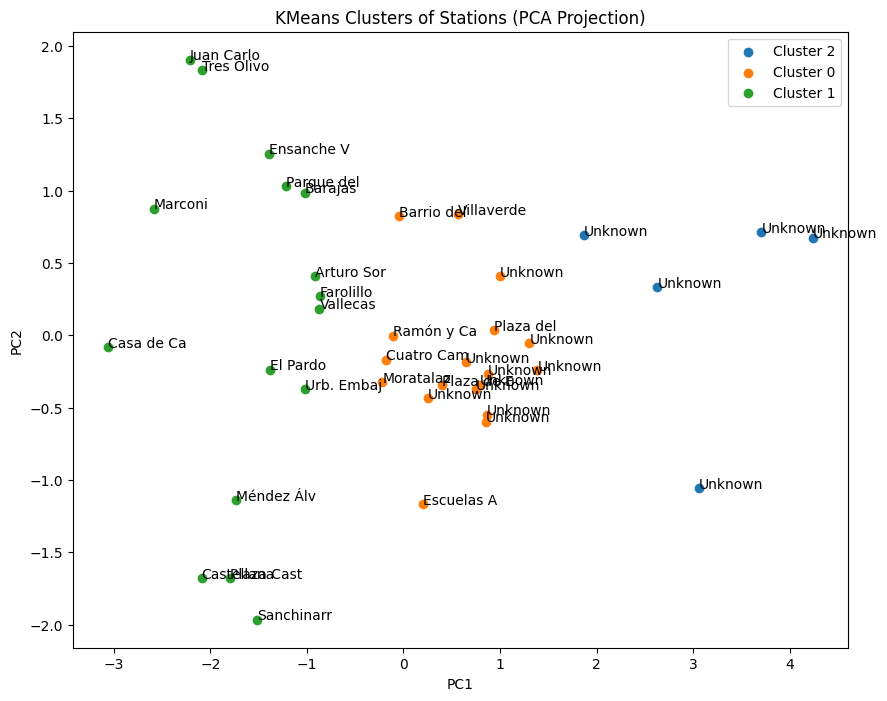

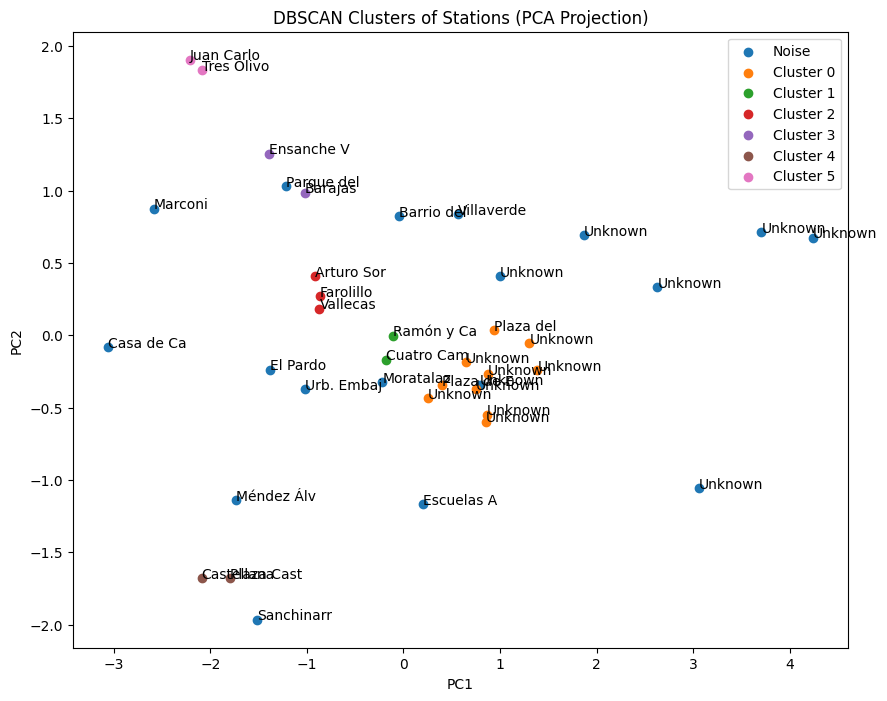

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
reduced = pca.fit_transform(features_scaled)

plt.figure(figsize=(10, 8))
for cluster in station_means['kmeans_cluster'].unique():
    idx = station_means['kmeans_cluster'] == cluster
    plt.scatter(reduced[idx, 0], reduced[idx, 1], label=f'Cluster {cluster}')
    for i in station_means[idx].index:
        plt.text(reduced[i, 0], reduced[i, 1], station_means.loc[i, 'name'][:10])  # Short name

plt.title('KMeans Clusters of Stations (PCA Projection)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.show()

# For DBSCAN
plt.figure(figsize=(10, 8))
for cluster in station_means['dbscan_cluster'].unique():
    idx = station_means['dbscan_cluster'] == cluster
    label = 'Noise' if cluster == -1 else f'Cluster {cluster}'
    plt.scatter(reduced[idx, 0], reduced[idx, 1], label=label)
    for i in station_means[idx].index:
        plt.text(reduced[i, 0], reduced[i, 1], station_means.loc[i, 'name'][:10])

plt.title('DBSCAN Clusters of Stations (PCA Projection)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.show()

##Observations of Extra Feature 2

KMeans Clusters: Typically 3 groups:
- Cluster with high NO₂, low O₃: Traffic/urban stations (similarity: vehicle emissions dominate).
- Cluster with high O₃, low NO₂: Suburban stations (difference: photochemical formation away from traffic).
- Cluster with balanced/moderate levels: Mixed or industrial (e.g., PM higher).

###DBSCAN Clusters:
Detects dense groups and noise/outliers (e.g., unique industrial stations like Marconi).



###Similarities/Differences:
Traffic stations cluster together due to NO₂ dominance from vehicles; suburban differ with higher O₃ from secondary formation. This reveals spatial pollution profiles: central city vs. outskirts.